# Read and process groundwater data

In [6]:
import pandas as pd
import xlrd
import os
import glob
import matplotlib.pyplot as plt

In [4]:
path = os.getcwd()
os.chdir('raw_data')
datapath = os.getcwd()
os.chdir(path)

xls_files = glob.glob(os.path.join(datapath, "*.xlsx"))
  
  
# loop over the list of xls files
ind = 0
diver_names={}
for f in xls_files:
    # read the csv file
    df = pd.read_excel(f)
    # remove double copied parts of the logged data from the raw data files
    df=df.drop_duplicates()  
    # print the location and filename for check
    print('Location:', f)
    print('File Name:', f.split("\\")[-1])
    # merge all data in 1 dataframe
    if ind == 0:
        #First data frame loaded
        GWdata = df
    else:
        # Paste the rest to this dataframe
        GWdata = GWdata.append(df, ignore_index=True)
    
    ind = ind + 1 

Location: C:\Users\sgarre\PycharmProjects\onderzoekskouter_water\groundwater\raw_data\ILVO_210701135826_AP825.xlsx
File Name: ILVO_210701135826_AP825.xlsx
Location: C:\Users\sgarre\PycharmProjects\onderzoekskouter_water\groundwater\raw_data\ILVO_210701140247_AP707.xlsx
File Name: ILVO_210701140247_AP707.xlsx
Location: C:\Users\sgarre\PycharmProjects\onderzoekskouter_water\groundwater\raw_data\ILVO_210701140912_AZ649.xlsx
File Name: ILVO_210701140912_AZ649.xlsx
Location: C:\Users\sgarre\PycharmProjects\onderzoekskouter_water\groundwater\raw_data\ILVO_210701141446_AG083.xlsx
File Name: ILVO_210701141446_AG083.xlsx
Location: C:\Users\sgarre\PycharmProjects\onderzoekskouter_water\groundwater\raw_data\ILVO_210701141936_CA186.xlsx
File Name: ILVO_210701141936_CA186.xlsx
Location: C:\Users\sgarre\PycharmProjects\onderzoekskouter_water\groundwater\raw_data\ILVO_210701142455_CA969.xlsx
File Name: ILVO_210701142455_CA969.xlsx
Location: C:\Users\sgarre\PycharmProjects\onderzoekskouter_water\groun

In [11]:
loggers = GWdata.SerialNumber.unique()
loggers[:]

array(['AP825', 'AP707', 'AZ649', 'AG083', 'CA186', 'CA969', 'AP689'],
      dtype=object)

### Plot raw data for visual check

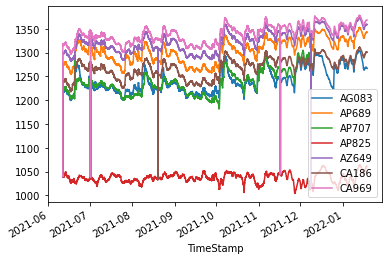

In [27]:
loggers = GWdata.SerialNumber.unique()

# gca stands for 'get current axis'
ax = plt.gca()

GWdata.groupby('SerialNumber')['Pressure'].plot(kind='line',x='TimeStamp',y='Pressure',ax=ax, legend= True)


plt.show()

In [28]:
GWdata

,MonitoringPoint,SerialNumber,Pressure,Temperature,Conductivity,WaterLevel,WaterLevelReference,Salinity
TimeStamp,,,,,,,,
2021-06-11 09:00:00,ILVO,AP825,1040.750000,22.500000,NaN,NaN,NaN,NaN
2021-06-11 09:05:00,ILVO,AP825,1040.700000,22.460000,NaN,NaN,NaN,NaN
2021-06-11 09:10:00,ILVO,AP825,1040.700000,22.426667,NaN,NaN,NaN,NaN
2021-06-11 09:15:00,ILVO,AP825,1041.125000,22.403333,NaN,NaN,NaN,NaN
2021-06-11 09:20:00,ILVO,AP825,1041.500000,22.390000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-01-18 07:08:15,ILVO,AP689,1342.791667,9.843333,NaN,NaN,NaN,NaN
2022-01-18 08:08:15,ILVO,AP689,1342.791667,9.813333,NaN,NaN,NaN,NaN
2022-01-18 09:08:15,ILVO,AP689,1342.791667,9.780000,NaN,NaN,NaN,NaN


pandas._libs.tslibs.timestamps.Timestamp